# MATH50003 Numerical Analysis: Problem Sheet 4

This problem sheet explores least squares, the QR decomposition including for
tridiagonal matrices,
and the PLU decompositions.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [1]:
using LinearAlgebra, Plots

## 1. Least squares and QR decompositions

**Problem 1.1** Find and plot the best least squares fit of ${1 \over 5x^2 + 1}$ by degree $n$
polynomials for $n = 0,\ldots,10$ at 1000 evenly spaced points between $0$ and $1$.

In [2]:
m,n = 1000,11

x = range(0,1; length=m)
f = 1 ./ (5(x .^ 2) .+ 1)

A = x .^ (0:10)'
Q1, R = qr(A)
Q = Q1[:,1:n]

p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = R \ Q'f

11-element Vector{Float64}:
    1.0000746068599236
   -0.010608194615438887
   -4.639507495711512
   -5.16299945374189
   63.08846292207689
 -153.86701817753865
  187.03791371271396
 -116.20258645341966
   22.663235555356938
   11.234151737538024
   -4.974486352705077

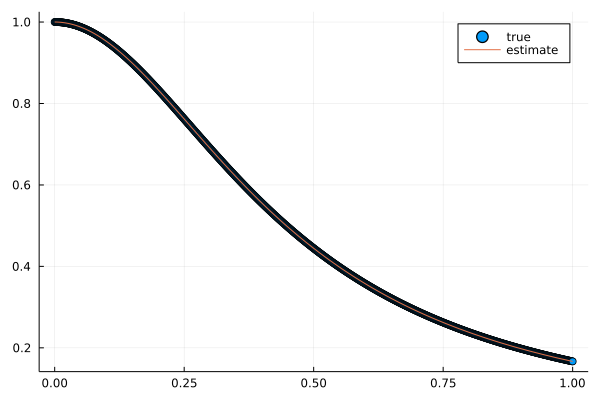

In [3]:
p = x -> p0 + p1*x + p2*x^2 + p3*x^3 + p4*x^4 + p5*x^5 + p6*x^6+ p7*x^7+ p8*x^8+ p9*x^9+ p10*x^10
scatter(x, f; label="true", legend=:topright)
plot!(x, p.(x); label="estimate")

**Problem 1.2⋆** Show that every matrix has a QR decomposition such that the diagonal of $R$ is non-negative.
Make sure to inlude the case of more columns than rows.

**Problem 1.3⋆** Show that the QR decomposition of a square invertible matrix is unique, 
provided that the diagonal of $R$ is positive.


## 2. Gram–Schmidt

**Problem 2.1⋆** The modified Gram–Schmidt algorithm is a slight variation of Gram–Schmidt where
instead of computing
$$
𝐯_j := 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k
$$
we compute it step-by-step:
$$
\begin{align*}
𝐯_j^1 &:= 𝐚_j \\
𝐯_j^{k+1} &:= 𝐯_j^k - 𝐪_k^\top 𝐯_j^k 𝐪_k
\end{align*}
$$
Show that $𝐯_j^k = 𝐯_j$. 

**Problem 2.2** Complete the following
function implementing the modified Gram–Schmidt algorithm:

In [4]:
function modifiedgramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        # TODO: Implement the Modified Gram–Schmidt algorthm
        vj = A[j,:]
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[j,:]
            vj -= Q[:,k]'*vj*Q[:,k]
        end
        R[j,j] = norm(vj)
        Q[:,j] = vj/R[j,j]
    end
    Q,R
end

function gramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end

gramschmidt (generic function with 1 method)

In [5]:
m,n = 1000,1000
A = randn(m,n)
Q1,R1 = gramschmidt(A)
Q2,R2 = modifiedgramschmidt(A)


([0.04708126722249865 0.0020402314435799596 … 0.014147968785879188 -0.019352784474949578; 0.014699374757097976 -0.01860966932338522 … -0.0066659922035715215 0.0024679806301015177; … ; -0.01990298505890421 0.015289713475195775 … 0.011573593071617747 -0.01833494649130255; 0.0004026154381107593 0.061041163519522074 … -0.0446569169492492 -0.04105595390257556], [31.594604016714847 -1.600925089925033 … 0.8659442193275314 0.29710489104401255; 0.0 31.0616305265759 … -0.681613618081564 -0.025808695964964982; … ; 0.0 0.0 … 1.1016291657869506 1.2336516719224009; 0.0 0.0 … 0.0 0.42111323899167374])

In [6]:
norm(Q1'Q1-I)

9.496832183695766e-12

In [7]:
norm(Q2'Q2-I)

1.4074796943526407e-12

**Problem 2.3** Compare the orthogonality of `Q` between `gramschmidt` and `modifiedgramschmidt`
when applied to a `300 × 300` random matrix.

## 3. Householder reflections


**Problem 3.1**
Complete the definition of `Reflections` which supports a sequence of Householder reflections,
that is, 
$$
Q = Q_{𝐯_1} \cdots Q_{𝐯_n}
$$
where the vectors are stored as a matrix `V` whose $j$-th column is $𝐯_j$.

In [3]:
struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

import Base: *, size, getindex

size(Q::Reflections) = (size(Q.v,1), size(Q.v,1))


function *(Q::Reflections, x::AbstractVector)
    # TODO: Apply Q in O(mn) operations
    for j = 1:size(x)
        x -= 2Q.V[:,j] * dot(Q.V[:,j], x)
    end
end

function getindex(Q::Reflections, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(mn) operations (hint: use *)
    tmp = zeros(size(Q.v[1, :]))
    tmp[j] = 1
    (Q*tmp)[k]
end

getindex (generic function with 220 methods)

**Problem 3.2** Complete the following function that implements
 Householder QR using only $O(mn^2)$ operations:

In [9]:
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Reflections(Matrix(1.0I, m, n))
    for j = 1:n
        # TODO: populate Q and R using O(m*j) operations
        
    end
    Q,R
end

householderqr (generic function with 1 method)

## 4. Banded QR with Given's rotations

**Problem 4.1⋆**  Describe an algorithm for computing the QR decomposition
of a tridiagonal matrix using rotations instead of reflections to upper-triangularise
column-by-column.

**Problem 4.2** Implement `Rotations` which represents an orthogonal matrix `Q` that is a product
 of rotations of angle `θ[k]`, each acting on the entries `k:k+1`.

In [10]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T}
end

import Base: *, size, getindex

size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)


function *(Q::Rotations, x::AbstractVector)
    # TODO: Apply Q in O(n) operations
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)
end

getindex (generic function with 326 methods)

**Problem 4.3** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition that only takes $O(n)$ operations:

In [11]:
function bandedqr(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n-1), zeros(n-2))
    for j = 1:n-1
        # TODO: populate Q and R
    end
    Q,R
end

bandedqr (generic function with 1 method)

**Problem 4.4⋆** Could one redesign the above to only use IEEE operatations (addition, multiplication, square-roots, 
avoiding calls `atan`, `cos`, and `sin`)?
Would it have been possible to implement this algorithm using reflections?
If so, what would be the structure of a matrix whose columns are the vectors of reflections?

## 5. PLU decomposition

**Problem 5.1⋆** Compute the PLU decompositions for the following matrices:
$$
\begin{bmatrix}
0 & 2 & 1 \\
2 & 6 & 1 \\
1 & 1 & 4
\end{bmatrix},
\begin{bmatrix}
1 & 2 & -1 & 0 \\
2 & 4 & -2 & 1 \\
-3 & -5 & 6 & 1 \\
-1 & 2 & 8 & -2
\end{bmatrix}
$$